In [20]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import random 
import stormeunice as eun
import multiprocessing
import glob
from cmcrameri import cm

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

sns.set_theme(style="white")
sns.set_style("white")
%matplotlib inline

random.seed(10)

# Import data

In [2]:
P1 = multiprocessing.Pool(40)

ifs_tracks = P1.map(eun.lagrangian.Lagrange.import_medr_tracks_TE, 
                    glob.glob('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_[!2]*'))

P1.close()

ifs_tracks = pd.concat(ifs_tracks)
ifs_tracks['date'] = pd.to_datetime(ifs_tracks.loc[:,['year','month','day','hour']])

## add era track in
era_track = pd.read_csv('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_2022_0',
                        skipinitialspace=True)

era_track['expid'] = 'era5'
era_track['experiment'] = 'era5'
era_track['inidate'] = pd.to_datetime('2022-01-01')
era_track['number'] = 0
era_track['date'] = pd.to_datetime(era_track.loc[:,['year','month','day','hour']])

all_tracks = pd.concat([ifs_tracks,era_track])

eunice_track = era_track.query('track_id==5')

In [3]:
ifs_tracks_filter = ifs_tracks.groupby(['track_id','inidate','experiment','number']).agg(dict(date=min, day=np.size, lon=lambda x: x.iloc[0], lat=lambda x: x.iloc[0], msl=min))
eunice_filter = eunice_track.groupby(['track_id','inidate','experiment','number']).agg(dict(date=min, day=np.size, lon=lambda x: x.iloc[0], lat=lambda x: x.iloc[0], msl=min)).iloc[0]

# starttime criterion - must be detected within 12 hours (before or after) the ERA5 track detectino time
starttime_crit = (ifs_tracks_filter.date - eunice_filter.date).dt.total_seconds().abs()<(12*60*60)
# starting location criterion - must start within 10 degrees of the ERA5 track starting point
startloc_crit = np.sqrt((ifs_tracks_filter.lon-eunice_filter.lon)**2+(ifs_tracks_filter.lat-eunice_filter.lat)**2)<10
# depth criterion - must reach a depth of at least 980 hPa
minmsl_crit = ifs_tracks_filter.msl < 98000

ifs_tracks_filtered = ifs_tracks_filter.loc[starttime_crit&startloc_crit&minmsl_crit]
ifs_eunice_list = ifs_tracks.set_index(['track_id','inidate','experiment','number']).sort_index().loc[ifs_tracks_filtered.index].reset_index()

In [4]:
multi_track_members = ifs_eunice_list.groupby(['inidate','experiment','number','track_id']).agg(dict(year = lambda x: 1)).groupby(['inidate','experiment','number']).count().query('year > 1')

for idx in multi_track_members.index:
    track_dists = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={}'.format(*idx)).groupby('track_id').apply(lambda x: eun.lagrangian.Lagrange.eunice_dist(x,eunice_track=eunice_track))
    num_reject = track_dists.idxmax()
    ifs_eunice_list_idx = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={} & track_id=={}'.format(*idx,num_reject)).index
    ifs_eunice_list = ifs_eunice_list.drop(ifs_eunice_list_idx)

In [5]:
ERA5_tracks = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/ERA5/EU025/sfc/2022.h5')
ERA5_eunice_track = ERA5_tracks.query('uid=="202202079"')

ERA5_data = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc').sel(time=ERA5_eunice_track.date.values)
ERA5_data['centroid_lon'] = ('time',(ERA5_eunice_track.long*4).round()/4)
ERA5_data['centroid_lat'] = ('time',(ERA5_eunice_track.lat*4).round()/4)

ERA5_eunice_stormframe = ERA5_data.groupby('time').apply(eun.lagrangian.Lagrange.lagrangian_frame)

In [6]:
%%capture 
# Ignore outputs

curr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/pl/pf/extravars/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe_max_deepening(x, ifs_eunice_list=ifs_eunice_list, sfc=False),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')
pi_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/pl/pf/extravars/*.nc',
                              preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe_max_deepening(x, ifs_eunice_list=ifs_eunice_list, sfc=False),
                              combine='nested',
                              concat_dim=['inidate'],
                              parallel=True, 
                              engine='netcdf4')
incr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/pl/pf/extravars/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe_max_deepening(x, ifs_eunice_list=ifs_eunice_list,sfc=False),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')

# Pressure surface lagrangians

## Specific humidity at 850hPa

/tmp/user/27529/ipykernel_1915178/3617845991.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/3617845991.py:15: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,i].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_1915178/3617845991.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/3617845991.py:15: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,i].set_xlabel('lon from storm centre'

Text(0.5, -0.7500000000000053, 'lon from storm centre')

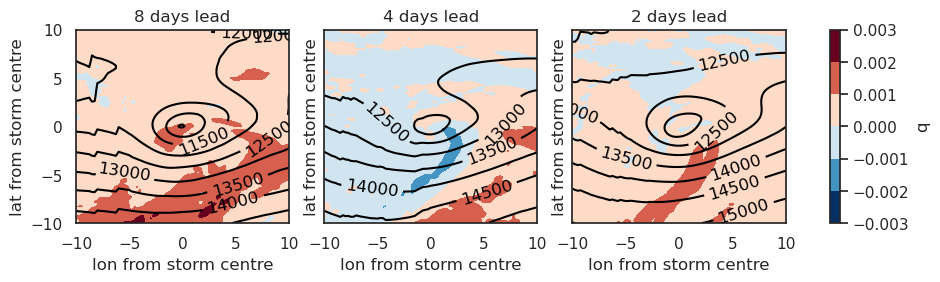

In [7]:
lev = 850
cplot = (incr_storms.q.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.q.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate')

# geopotential height contours
z_min = 10000
z_max = 15000
longitude = incr_storms.storm_lon.values
latitude = incr_storms.storm_lat.values
for i in range(0,3):
    inidates = ['2022-02-10', '2022-02-14', '2022-02-16']
    z_vals = curr_storms.z.sel(timestep=0, level=lev, inidate=inidates[i]).mean('number').squeeze().values
    clevs_p = np.linspace(z_min, z_max, 11) 
    cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
    plt.clabel(cs, fmt='%d')
    cplot.axes[0,i].set_xlabel('lon from storm centre')

# titles etc
cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')
cplot.axes[0,0].set_ylabel('lat from storm centre')
cplot.axes[0,1].set_ylabel('lat from storm centre')
cplot.axes[0,2].set_ylabel('lat from storm centre')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')

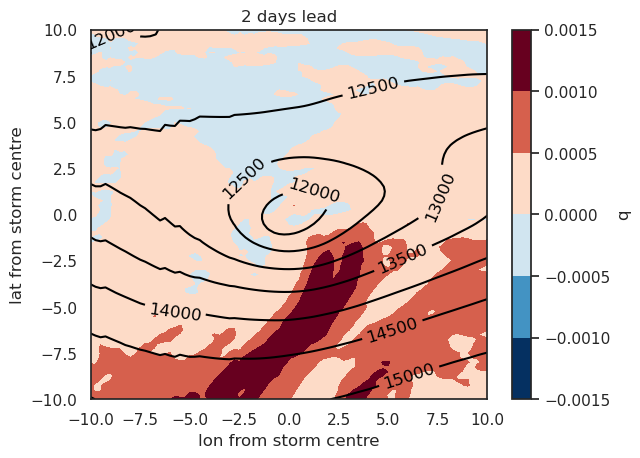

In [8]:
lev = 850
cplot = (incr_storms.q.sel(timestep=0, level=lev, inidate='2022-02-16').mean('number').squeeze() - pi_storms.q.sel(timestep=0, level=lev, inidate='2022-02-16').mean('number').squeeze()).plot.contourf()
z_min = 10000
z_max = 15000
longitude = incr_storms.storm_lon.values
latitude = incr_storms.storm_lat.values
z_vals = curr_storms.z.sel(timestep=0, level=lev, inidate='2022-02-16').mean('number').squeeze().values
clevs_p = np.linspace(z_min, z_max, 11) 
cs = cplot.axes.contour(longitude, latitude, z_vals, clevs_p, colors='black')
plt.clabel(cs, fmt='%d')

# titles etc
cplot.axes.set_title('2 days lead')
cplot.axes.set_ylabel('lat from storm centre')
cplot.axes.set_xlabel('lon from storm centre')

plt.savefig('figures/11_poster_q_2022-02-16.png')
plt.savefig('figures/11_poster_q_2022-02-16.pdf')

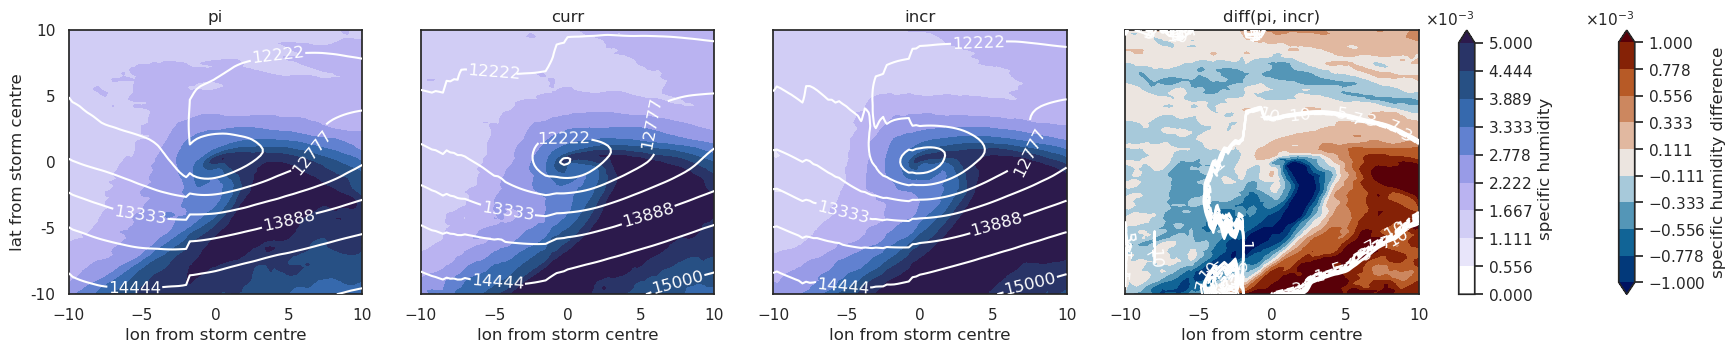

In [31]:
# setup -------------------------
fig, axes = plt.subplots(1, 4, figsize=(20, 3.3), sharey=True)
vmin = 0
vmax = 0.005
lev_number = 10
ts = 0
ini = '2022-02-14'
z_min = 10000
z_max = 15000
num_levels_z = 10
plev = 850

# pi -------------------------
pi = pi_storms.sel(inidate=ini, timestep=ts, level=plev).squeeze().mean(dim = 'number')
c = pi.q.plot.contourf(levels = lev_number, cmap=cm.devon_r, ax=axes[0], add_colorbar=False, vmin = vmin, vmax = vmax)
axes[0].set_ylabel('lat from storm centre')
axes[0].set_xlabel('lon from storm centre')
axes[0].set_title('pi')

# isolines
clevs_p = np.linspace(z_min, z_max, num_levels_z) 
cs = axes[0].contour(pi.storm_lon.values, pi.storm_lat.values,
                     pi.z,
                     clevs_p, colors='white',
                     zorder = 16)
plt.clabel(cs, fmt='%d')

# y axis number formatting
majorLocator2   = MultipleLocator(5)
majorFormatter2 = FormatStrFormatter('%d')
minorLocator2   = MultipleLocator(5)
axes[0].yaxis.set_major_locator(majorLocator2)
axes[0].yaxis.set_major_formatter(majorFormatter2)
axes[0].yaxis.set_minor_locator(minorLocator2)

# curr -------------------------
curr = curr_storms.sel(inidate=ini, timestep=ts, level=plev).squeeze().mean(dim = 'number')
curr.q.plot.contourf(levels = lev_number, cmap=cm.devon_r, ax=axes[1], add_colorbar=False, vmin = vmin, vmax = vmax)
axes[1].set_ylabel('')
axes[1].set_xlabel('lon from storm centre')
axes[1].set_title('curr')

# isolones
clevs_p = np.linspace(z_min, z_max, num_levels_z) 
cs = axes[1].contour(curr.storm_lon.values, curr.storm_lat.values,
                     curr.z,
                     clevs_p, colors='white',
                     zorder = 16)
plt.clabel(cs, fmt='%d')

# incr -------------------------
incr = incr_storms.sel(inidate=ini, timestep=ts, level=plev).squeeze().mean(dim = 'number')
incr.q.plot.contourf(levels = lev_number, cmap=cm.devon_r, ax=axes[2], add_colorbar=False, vmin = vmin, vmax = vmax)
axes[2].set_ylabel('')
axes[2].set_xlabel('lon from storm centre')
axes[2].set_title('incr')

# isolines
clevs_p = np.linspace(z_min, z_max, num_levels_z) 
cs = axes[2].contour(incr.storm_lon.values, incr.storm_lat.values,
                     incr.z,
                     clevs_p, colors='white',
                     zorder = 16)
plt.clabel(cs, fmt='%d')

# diff -------------------------
diff = incr - pi
c_diff = diff.q.plot.contourf(levels = lev_number, cmap=cm.vik, ax=axes[3], add_colorbar=False, vmin = -0.001, vmax = 0.001)
axes[3].set_ylabel('')
axes[3].set_xlabel('lon from storm centre')
axes[3].set_title('diff(pi, incr)');

# isolines
clevs_p = np.linspace(-10, 10, num_levels_z) 
cs = axes[3].contour(diff.storm_lon.values, diff.storm_lat.values,
                     diff.z,
                     clevs_p, colors='white',
                     zorder = 16)
plt.clabel(cs, fmt='%d')

# cbars -------------------------
# cbar_num_format = "%0.2f"
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

cax = plt.axes([0.82, 0.1, 0.008, 0.8])  # left, bottom, width, height
cbar = plt.colorbar(c, cax=cax, label='specific humidity')
cax.ticklabel_format(style='scientific', useMathText=True, scilimits=(0,0))

cax_diff = plt.axes([0.9, 0.1, 0.008, 0.8])
cbar_diff = plt.colorbar(c_diff, cax=cax_diff, label='specific humidity difference')
cax_diff.ticklabel_format(style='scientific', useMathText=True, scilimits=(0,0))

# save -------------------------
# plt.savefig('figures/11_specific_humidity_'+ini+'_diff_and_exp.png')
# plt.savefig('figures/11_specific_humidity_'+ini+'_diff_and_exp.pdf')

## Specific humidity at 500hPa

/tmp/user/27529/ipykernel_1915178/975131042.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/975131042.py:13: UserWarning: No contour levels were found within the data range.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/975131042.py:15: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,i].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_1915178/975131042.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/9

Text(0.5, -0.7500000000000053, 'lon from storm centre')

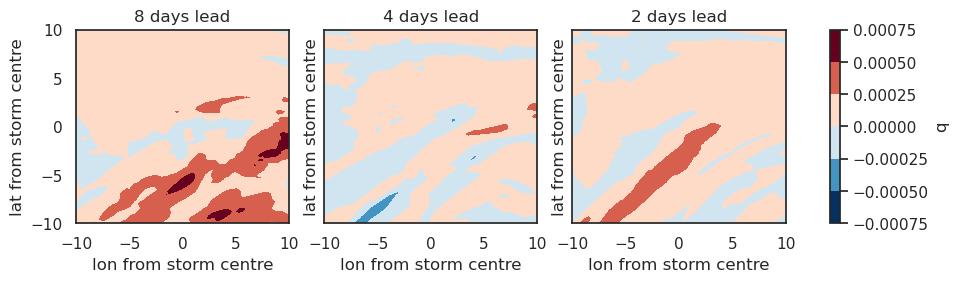

In [10]:
lev = 500
cplot = (incr_storms.q.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.q.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate')

# geopotential height contours
z_min = 10000
z_max = 15000
longitude = incr_storms.storm_lon.values
latitude = incr_storms.storm_lat.values
for i in range(0,3):
    inidates = ['2022-02-10', '2022-02-14', '2022-02-16']
    z_vals = curr_storms.z.sel(timestep=0, level=lev, inidate=inidates[i]).mean('number').squeeze().values
    clevs_p = np.linspace(z_min, z_max, 11) 
    cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
    plt.clabel(cs, fmt='%d')
    cplot.axes[0,i].set_xlabel('lon from storm centre')

# titles etc
cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')
cplot.axes[0,0].set_ylabel('lat from storm centre')
cplot.axes[0,1].set_ylabel('lat from storm centre')
cplot.axes[0,2].set_ylabel('lat from storm centre')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')

/tmp/user/27529/ipykernel_1915178/567002329.py:12: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/567002329.py:12: UserWarning: No contour levels were found within the data range.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/567002329.py:14: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,i].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_1915178/567002329.py:12: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/5

Text(0.5, -0.7500000000000053, 'lon from storm centre')

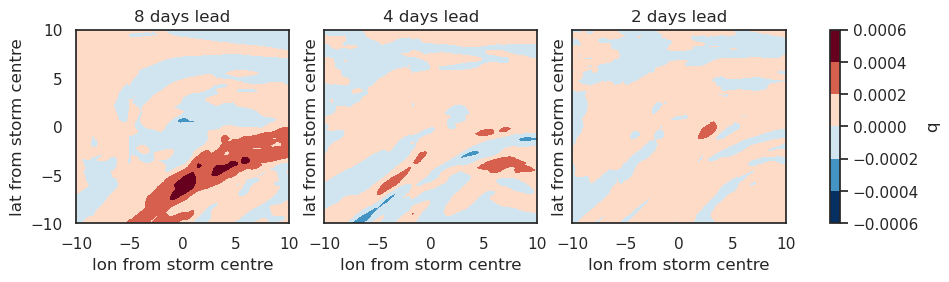

In [11]:
cplot = (curr_storms.q.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.q.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate')

# geopotential height contours
z_min = 10000
z_max = 15000
longitude = incr_storms.storm_lon.values
latitude = incr_storms.storm_lat.values
for i in range(0,3):
    inidates = ['2022-02-10', '2022-02-14', '2022-02-16']
    z_vals = curr_storms.z.sel(timestep=0, level=lev, inidate=inidates[i]).mean('number').squeeze().values
    clevs_p = np.linspace(z_min, z_max, 11) 
    cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
    plt.clabel(cs, fmt='%d')
    cplot.axes[0,i].set_xlabel('lon from storm centre')

# titles etc
cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')
cplot.axes[0,0].set_ylabel('lat from storm centre')
cplot.axes[0,1].set_ylabel('lat from storm centre')
cplot.axes[0,2].set_ylabel('lat from storm centre')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')

## Relative humidity at 850hPa

/tmp/user/27529/ipykernel_1915178/4292115010.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/4292115010.py:15: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,i].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_1915178/4292115010.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/4292115010.py:15: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,i].set_xlabel('lon from storm centre'

Text(0.5, -0.7500000000000053, 'lon from storm centre')

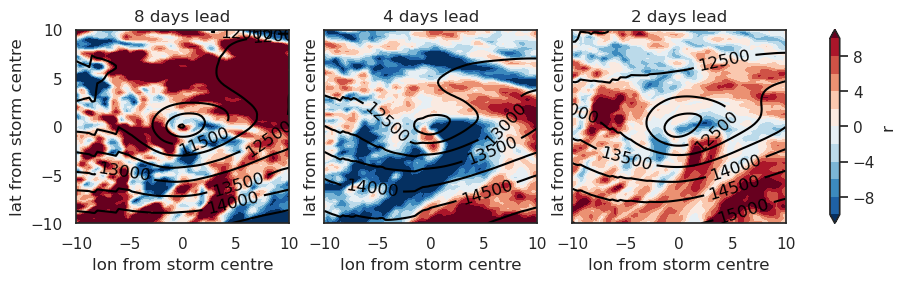

In [12]:
lev = 850
cplot = (incr_storms.r.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.r.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',
                                                                                                                                                    levels=np.linspace(-10,10,11))
# geopotential height contours
z_min = 10000
z_max = 15000
longitude = incr_storms.storm_lon.values
latitude = incr_storms.storm_lat.values
for i in range(0,3):
    inidates = ['2022-02-10', '2022-02-14', '2022-02-16']
    z_vals = curr_storms.z.sel(timestep=0, level=lev, inidate=inidates[i]).mean('number').squeeze().values
    clevs_p = np.linspace(z_min, z_max, 11) 
    cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
    plt.clabel(cs, fmt='%d')
    cplot.axes[0,i].set_xlabel('lon from storm centre')

# titles etc
cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')
cplot.axes[0,0].set_ylabel('lat from storm centre')
cplot.axes[0,1].set_ylabel('lat from storm centre')
cplot.axes[0,2].set_ylabel('lat from storm centre')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')

/tmp/user/27529/ipykernel_809275/2705774218.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_title('8 days lead')
/tmp/user/27529/ipykernel_809275/2705774218.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,1].set_title('4 days lead')
/tmp/user/27529/ipykernel_809275/2705774218.py:6: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,2].set_title('2 days lead')
/tmp/user/27529/ipykernel_809275/2705774218.py:8: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,0].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_809275/2705774218.py:9: DeprecationWarning: self.axes is deprecated since 2

Text(74.0, 0.5, 'lat from storm centre')

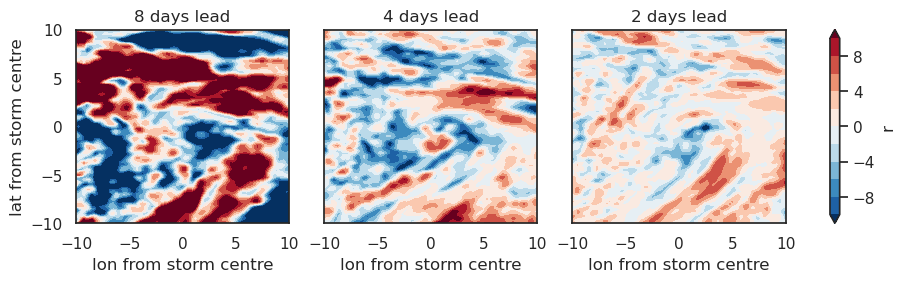

In [12]:
cplot = (curr_storms.r.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.r.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',
                                                                                                                                                    levels=np.linspace(-10,10,11))

# geopotential height contours
z_min = 10000
z_max = 15000
longitude = incr_storms.storm_lon.values
latitude = incr_storms.storm_lat.values
for i in range(0,3):
    inidates = ['2022-02-10', '2022-02-14', '2022-02-16']
    z_vals = curr_storms.z.sel(timestep=0, level=lev, inidate=inidates[i]).mean('number').squeeze().values
    clevs_p = np.linspace(z_min, z_max, 11) 
    cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
    plt.clabel(cs, fmt='%d')
    cplot.axes[0,i].set_xlabel('lon from storm centre')

# titles etc
cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')
cplot.axes[0,0].set_ylabel('lat from storm centre')
cplot.axes[0,1].set_ylabel('lat from storm centre')
cplot.axes[0,2].set_ylabel('lat from storm centre')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')

## Vertical velocity at 850hPa

/tmp/user/27529/ipykernel_1915178/4182523875.py:14: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/4182523875.py:16: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,i].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_1915178/4182523875.py:14: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/4182523875.py:16: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,i].set_xlabel('lon from storm centre'

Text(0.5, -0.7500000000000053, 'lon from storm centre')

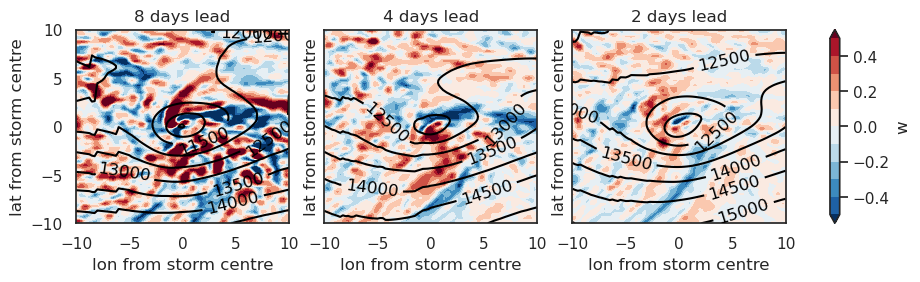

In [13]:
lev = 850
cplot = (incr_storms.w.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.w.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',
                                                                                                                                                    levels=np.linspace(-0.5,0.5,11))

# geopotential height contours
z_min = 10000
z_max = 15000
longitude = incr_storms.storm_lon.values
latitude = incr_storms.storm_lat.values
for i in range(0,3):
    inidates = ['2022-02-10', '2022-02-14', '2022-02-16']
    z_vals = curr_storms.z.sel(timestep=0, level=lev, inidate=inidates[i]).mean('number').squeeze().values
    clevs_p = np.linspace(z_min, z_max, 11) 
    cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
    plt.clabel(cs, fmt='%d')
    cplot.axes[0,i].set_xlabel('lon from storm centre')

# titles etc
cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')
cplot.axes[0,0].set_ylabel('lat from storm centre')
cplot.axes[0,1].set_ylabel('lat from storm centre')
cplot.axes[0,2].set_ylabel('lat from storm centre')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')

/tmp/user/27529/ipykernel_1915178/693819696.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/693819696.py:15: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,i].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_1915178/693819696.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/693819696.py:15: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,i].set_xlabel('lon from storm centre')
/t

Text(0.5, -0.7500000000000053, 'lon from storm centre')

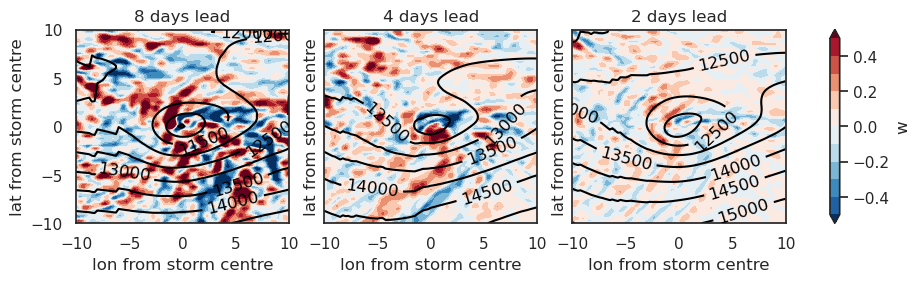

In [14]:
cplot = (curr_storms.w.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.w.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',
                                                                                                                                                    levels=np.linspace(-0.5,0.5,11))

# geopotential height contours
z_min = 10000
z_max = 15000
longitude = incr_storms.storm_lon.values
latitude = incr_storms.storm_lat.values
for i in range(0,3):
    inidates = ['2022-02-10', '2022-02-14', '2022-02-16']
    z_vals = curr_storms.z.sel(timestep=0, level=lev, inidate=inidates[i]).mean('number').squeeze().values
    clevs_p = np.linspace(z_min, z_max, 11) 
    cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
    plt.clabel(cs, fmt='%d')
    cplot.axes[0,i].set_xlabel('lon from storm centre')

# titles etc
cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')
cplot.axes[0,0].set_ylabel('lat from storm centre')
cplot.axes[0,1].set_ylabel('lat from storm centre')
cplot.axes[0,2].set_ylabel('lat from storm centre')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')

### No difference, current climate vertical velocity

/tmp/user/27529/ipykernel_1915178/3737230237.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/3737230237.py:15: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,i].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_1915178/3737230237.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/3737230237.py:15: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,i].set_xlabel('lon from storm centre'

Text(0.5, -0.7500000000000053, 'lon from storm centre')

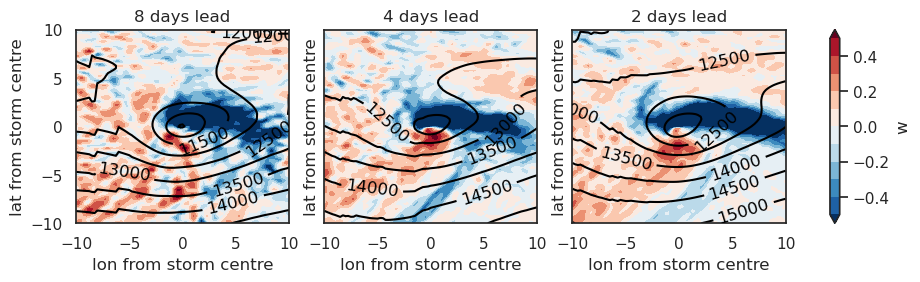

In [15]:
lev = 850
cplot = (curr_storms.w.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate', levels=np.linspace(-0.5,0.5,11))

# geopotential height contours
z_min = 10000
z_max = 15000
longitude = incr_storms.storm_lon.values
latitude = incr_storms.storm_lat.values
for i in range(0,3):
    inidates = ['2022-02-10', '2022-02-14', '2022-02-16']
    z_vals = curr_storms.z.sel(timestep=0, level=lev, inidate=inidates[i]).mean('number').squeeze().values
    clevs_p = np.linspace(z_min, z_max, 11) 
    cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
    plt.clabel(cs, fmt='%d')
    cplot.axes[0,i].set_xlabel('lon from storm centre')

# titles etc
cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')
cplot.axes[0,0].set_ylabel('lat from storm centre')
cplot.axes[0,1].set_ylabel('lat from storm centre')
cplot.axes[0,2].set_ylabel('lat from storm centre')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')

## Vorticity at 850hPa

/tmp/user/27529/ipykernel_1915178/2687044948.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/2687044948.py:15: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,i].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_1915178/2687044948.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/2687044948.py:15: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,i].set_xlabel('lon from storm centre'

Text(0.5, -0.7500000000000053, 'lon from storm centre')

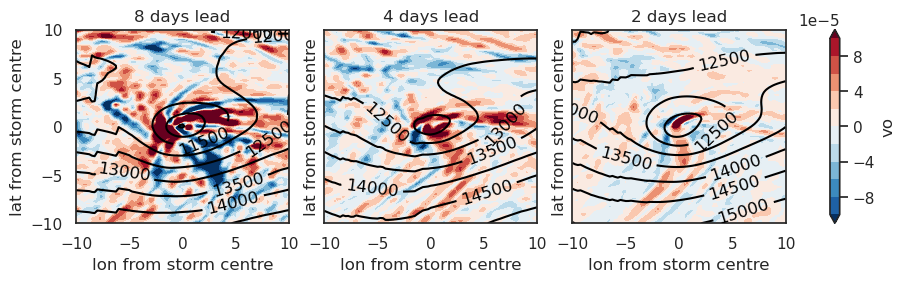

In [16]:
lev = 850
cplot = (incr_storms.vo.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.vo.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',
                                                                                                                                                                                levels=np.linspace(-0.0001, 0.0001,11))
# geopotential height contours
z_min = 10000
z_max = 15000
longitude = incr_storms.storm_lon.values
latitude = incr_storms.storm_lat.values
for i in range(0,3):
    inidates = ['2022-02-10', '2022-02-14', '2022-02-16']
    z_vals = curr_storms.z.sel(timestep=0, level=lev, inidate=inidates[i]).mean('number').squeeze().values
    clevs_p = np.linspace(z_min, z_max, 11) 
    cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
    plt.clabel(cs, fmt='%d')
    cplot.axes[0,i].set_xlabel('lon from storm centre')

# titles etc
cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')
cplot.axes[0,0].set_ylabel('lat from storm centre')
cplot.axes[0,1].set_ylabel('lat from storm centre')
cplot.axes[0,2].set_ylabel('lat from storm centre')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')

## Vorticity at 500hPa

/tmp/user/27529/ipykernel_1915178/2919311180.py:14: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/2919311180.py:14: UserWarning: No contour levels were found within the data range.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/2919311180.py:16: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,i].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_1915178/2919311180.py:14: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_19151

Text(0.5, -0.7500000000000053, 'lon from storm centre')

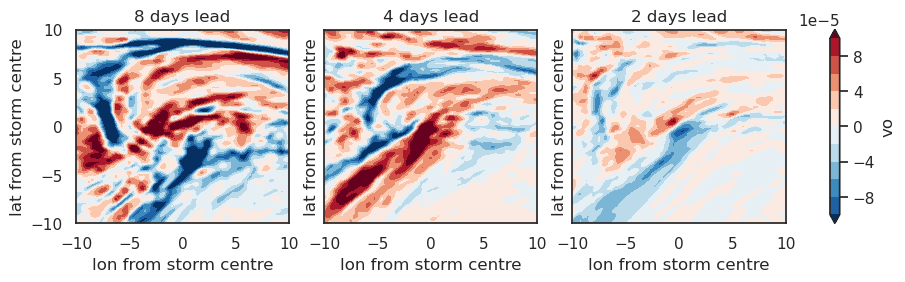

In [17]:
lev = 500
cplot =(incr_storms.vo.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.vo.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',
                                                                                                                                                      levels=np.linspace(-0.0001, 0.0001,11))

# geopotential height contours
z_min = 10000
z_max = 15000
longitude = incr_storms.storm_lon.values
latitude = incr_storms.storm_lat.values
for i in range(0,3):
    inidates = ['2022-02-10', '2022-02-14', '2022-02-16']
    z_vals = curr_storms.z.sel(timestep=0, level=lev, inidate=inidates[i]).mean('number').squeeze().values
    clevs_p = np.linspace(z_min, z_max, 11) 
    cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
    plt.clabel(cs, fmt='%d')
    cplot.axes[0,i].set_xlabel('lon from storm centre')

# titles etc
cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')
cplot.axes[0,0].set_ylabel('lat from storm centre')
cplot.axes[0,1].set_ylabel('lat from storm centre')
cplot.axes[0,2].set_ylabel('lat from storm centre')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')

## Vorticity at 250hPa

/tmp/user/27529/ipykernel_1915178/3583930008.py:14: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/3583930008.py:14: UserWarning: No contour levels were found within the data range.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/3583930008.py:16: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,i].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_1915178/3583930008.py:14: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_19151

Text(0.5, -0.7500000000000053, 'lon from storm centre')

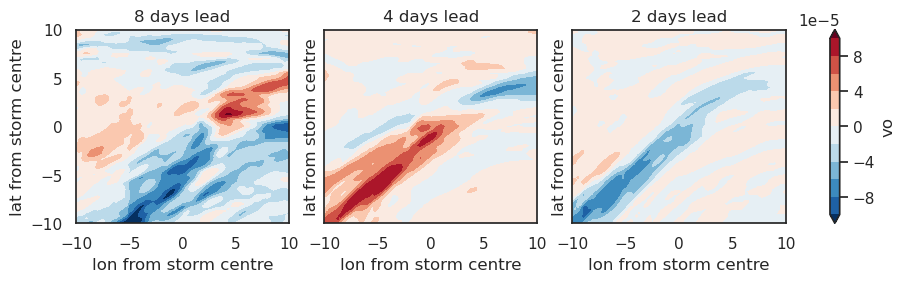

In [18]:
lev = 250
cplot =(incr_storms.vo.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.vo.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',
                                                                                                                                                      levels=np.linspace(-0.0001, 0.0001,11))

# geopotential height contours
z_min = 10000
z_max = 15000
longitude = incr_storms.storm_lon.values
latitude = incr_storms.storm_lat.values
for i in range(0,3):
    inidates = ['2022-02-10', '2022-02-14', '2022-02-16']
    z_vals = curr_storms.z.sel(timestep=0, level=lev, inidate=inidates[i]).mean('number').squeeze().values
    clevs_p = np.linspace(z_min, z_max, 11) 
    cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
    plt.clabel(cs, fmt='%d')
    cplot.axes[0,i].set_xlabel('lon from storm centre')

# titles etc
cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')
cplot.axes[0,0].set_ylabel('lat from storm centre')
cplot.axes[0,1].set_ylabel('lat from storm centre')
cplot.axes[0,2].set_ylabel('lat from storm centre')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')

## Temperature at 850 hPa

/tmp/user/27529/ipykernel_1915178/3104649635.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/3104649635.py:15: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,i].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_1915178/3104649635.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/3104649635.py:15: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,i].set_xlabel('lon from storm centre'

Text(0.5, -0.7500000000000053, 'lon from storm centre')

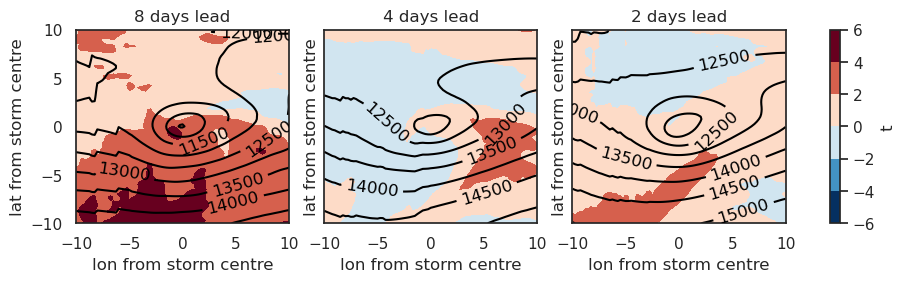

In [19]:
lev = 850
cplot =(incr_storms.t.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.t.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate')

# geopotential height contours
z_min = 10000
z_max = 15000
longitude = incr_storms.storm_lon.values
latitude = incr_storms.storm_lat.values
for i in range(0,3):
    inidates = ['2022-02-10', '2022-02-14', '2022-02-16']
    z_vals = curr_storms.z.sel(timestep=0, level=lev, inidate=inidates[i]).mean('number').squeeze().values
    clevs_p = np.linspace(z_min, z_max, 11) 
    cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
    plt.clabel(cs, fmt='%d')
    cplot.axes[0,i].set_xlabel('lon from storm centre')

# titles etc
cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')
cplot.axes[0,0].set_ylabel('lat from storm centre')
cplot.axes[0,1].set_ylabel('lat from storm centre')
cplot.axes[0,2].set_ylabel('lat from storm centre')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')

## Temperature at 500 hPa

/tmp/user/27529/ipykernel_1915178/3990886316.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/3990886316.py:13: UserWarning: No contour levels were found within the data range.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/3990886316.py:15: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,i].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_1915178/3990886316.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_19151

Text(0.5, -0.7500000000000053, 'lon from storm centre')

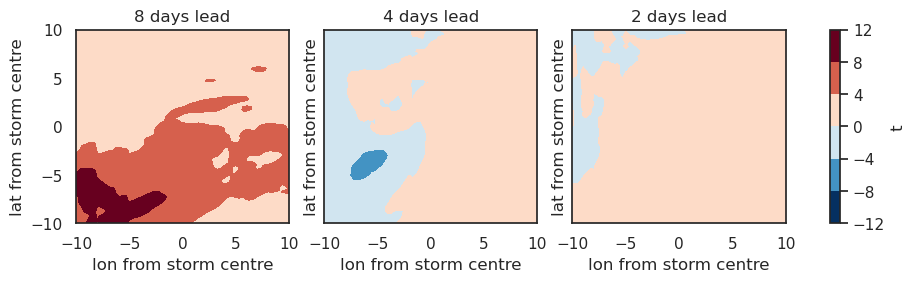

In [20]:
lev = 500
cplot =(incr_storms.t.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.t.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate')

# geopotential height contours
z_min = 10000
z_max = 15000
longitude = incr_storms.storm_lon.values
latitude = incr_storms.storm_lat.values
for i in range(0,3):
    inidates = ['2022-02-10', '2022-02-14', '2022-02-16']
    z_vals = curr_storms.z.sel(timestep=0, level=lev, inidate=inidates[i]).mean('number').squeeze().values
    clevs_p = np.linspace(z_min, z_max, 11) 
    cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
    plt.clabel(cs, fmt='%d')
    cplot.axes[0,i].set_xlabel('lon from storm centre')

# titles etc
cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')
cplot.axes[0,0].set_ylabel('lat from storm centre')
cplot.axes[0,1].set_ylabel('lat from storm centre')
cplot.axes[0,2].set_ylabel('lat from storm centre')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')

## Temperature at 250 hPa

/tmp/user/27529/ipykernel_1915178/1002058509.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/1002058509.py:13: UserWarning: No contour levels were found within the data range.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/1002058509.py:15: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,i].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_1915178/1002058509.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_19151

Text(0.5, -0.7500000000000053, 'lon from storm centre')

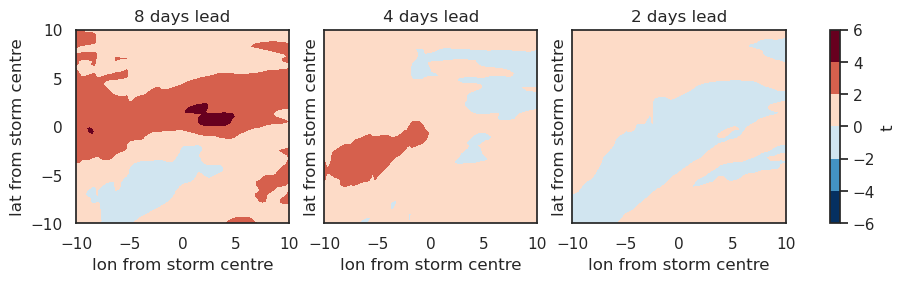

In [21]:
lev =250
cplot =(incr_storms.t.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.t.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate')

# geopotential height contours
z_min = 10000
z_max = 15000
longitude = incr_storms.storm_lon.values
latitude = incr_storms.storm_lat.values
for i in range(0,3):
    inidates = ['2022-02-10', '2022-02-14', '2022-02-16']
    z_vals = curr_storms.z.sel(timestep=0, level=lev, inidate=inidates[i]).mean('number').squeeze().values
    clevs_p = np.linspace(z_min, z_max, 11) 
    cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
    plt.clabel(cs, fmt='%d')
    cplot.axes[0,i].set_xlabel('lon from storm centre')

# titles etc
cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')
cplot.axes[0,0].set_ylabel('lat from storm centre')
cplot.axes[0,1].set_ylabel('lat from storm centre')
cplot.axes[0,2].set_ylabel('lat from storm centre')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')

## Divergence at 250 hPa

/tmp/user/27529/ipykernel_1915178/1474656935.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/1474656935.py:13: UserWarning: No contour levels were found within the data range.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_1915178/1474656935.py:15: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cplot.axes[0,i].set_xlabel('lon from storm centre')
/tmp/user/27529/ipykernel_1915178/1474656935.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
/tmp/user/27529/ipykernel_19151

Text(0.5, -0.7500000000000053, 'lon from storm centre')

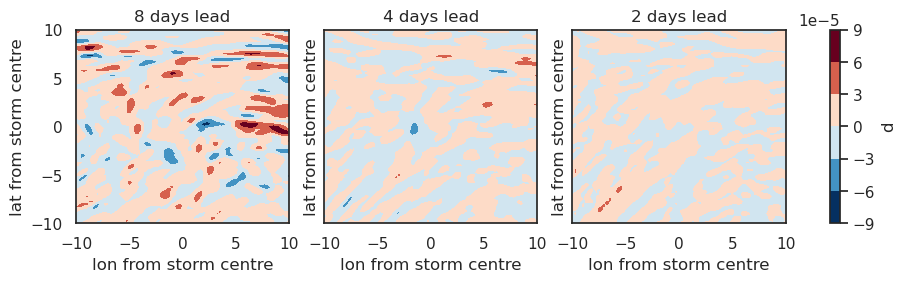

In [22]:
lev =250
cplot =(incr_storms.d.sel(timestep=0, level=lev).mean('number').squeeze() - pi_storms.d.sel(timestep=0, level=lev).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate')

# geopotential height contours
z_min = 10000
z_max = 15000
longitude = incr_storms.storm_lon.values
latitude = incr_storms.storm_lat.values
for i in range(0,3):
    inidates = ['2022-02-10', '2022-02-14', '2022-02-16']
    z_vals = curr_storms.z.sel(timestep=0, level=lev, inidate=inidates[i]).mean('number').squeeze().values
    clevs_p = np.linspace(z_min, z_max, 11) 
    cs = cplot.axes[0,i].contour(longitude, latitude, z_vals, clevs_p, colors='black')
    plt.clabel(cs, fmt='%d')
    cplot.axes[0,i].set_xlabel('lon from storm centre')

# titles etc
cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')
cplot.axes[0,0].set_ylabel('lat from storm centre')
cplot.axes[0,1].set_ylabel('lat from storm centre')
cplot.axes[0,2].set_ylabel('lat from storm centre')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')